# COGS 108 - EDA Checkpoint

## Names

- Ava Hamedi
- Marc Mendoza
- Jonathan Park
- Daniel Renteria
- Siena Rivera

<a id='research_question'></a>
# Research Question

Did California Air Quality significantly improve in different areas due to the COVID-19 Pandemic and the change in car traffic volume?

# Setup

In [1]:
# First make sure to have all packages installed on device (pip install pandas, numpy, seaborn, matplotlib, and etc)
# import all packages after installing pip
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(font_scale=2, style="white")
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
import geopandas as gpd
import pyproj as pyproj
import scipy.stats as stats
from scipy.stats import normaltest, ttest_ind
import patsy
import statsmodels.api as sm
import functools
# Our Warnings when importing code will make it harder to concentrate on what is important
import warnings
warnings.filterwarnings('ignore')

# Data Cleaning

## Table of Contents

- Air Quality in various regions
- Car Traffic 
- Gasoline Consumption 


## Air Quality (AQI) Data

### I. Annual Air Quality (AQI) by County
First we will focus on the Air Quality (AQI) Data given to the team by the EPA. These dataset contained information for the years of 2010-2021. We only want to focus on years 2010-2021, so we will be removing data that does not fit into our timeline. All Data use AQI (Air Quality Index). The Measurement AQI is calculated based on the average concentration of a particular pollutant measured over a standard time interval (24 hours for most pollutants, 8 hours for carbon monoxide and ozone). We will be using this dataset to help understand and show the trend of Air Quality throughout years 2010 until today. This way, we can get a trend of how AQI has changed over the years before and through COVID-19.


In [2]:
#importing data
aqi_county_path = ['datasets/annual_aqi_by_county_2010.csv', 
                 'datasets/annual_aqi_by_county_2011.csv', 
                 'datasets/annual_aqi_by_county_2012.csv', 
                 'datasets/annual_aqi_by_county_2013.csv', 
                 'datasets/annual_aqi_by_county_2014.csv', 
                 'datasets/annual_aqi_by_county_2015.csv', 
                 'datasets/annual_aqi_by_county_2016.csv', 
                 'datasets/annual_aqi_by_county_2017.csv', 
                 'datasets/annual_aqi_by_county_2018.csv',
                 'datasets/annual_aqi_by_county_2019.csv', 
                 'datasets/annual_aqi_by_county_2020.csv', 
                 'datasets/annual_aqi_by_county_2021.csv']

In [3]:
#parsing data
aqi_county_frames = []
for path in aqi_county_path:
    aqi_county_frames.append(pd.read_csv(path))
aqi_county = pd.concat(aqi_county_frames, ignore_index = True)

In [4]:
#columns to remove from files
aqi_county_bad = ['Days with AQI', 'Good Days', 'Moderate Days', 'Unhealthy for Sensitive Groups Days',
                  'Unhealthy Days', 'Very Unhealthy Days', 'Hazardous Days', 'Days CO', 'Days NO2',
                  'Days Ozone', 'Days SO2', 'Days PM2.5', 'Days PM10']

In [5]:
#dropping columns
aqi_county.drop(aqi_county_bad, axis = 1, inplace = True)

In [6]:
#dropping rows
aqi_county_CA = aqi_county[aqi_county['State']=='California']

In [7]:
#resetting index
aqi_county_CA.reset_index(drop=True, inplace = True)

In [8]:
aqi_county_CA.to_pickle('datasets/pickled_aqi.pkl')

aqi_county_CA.head()

,State,County,Year,Max AQI,90th Percentile AQI,Median AQI
0,California,Alameda,2010,179,68,43
1,California,Amador,2010,151,64,35
2,California,Butte,2010,126,84,47
3,California,Calaveras,2010,154,84,41
4,California,Colusa,2010,119,49,38


#### Columns
- State: The state in which the Air Quality was measured. In our case, it is only California.
- County: The county (of California) in which the Air Quality was measured.
- Year: The year the Air Quality was measured.
- Max AQI: The maximum AQI (worst air quality) that year.
- 90th Percentile AQI: The 90th percentile AQI value that year.
- Median AQI: The median AQI that year.

## Traffic Data

### II. Annual Daily Traffic Data 
In addition to Air Quality, our team wanted to look into the relationship between Air Quality and Car and Vehicular Traffic. The chosen datasets contain data and information on Annual Average Daily Traffic Volumes through years 2007 until 2020. We will be using this dataset to help understand the average amount of Annual daily traffic through the state of California. We found this information via data.ca.gov, through the data that CalTrans gathers on traffic volumes. We only want to focus on a more narrow area and scope, so we will be cleaning up the datasets to help provide us with the best information. This way, we can also get a trend of how Annual Daily Traffic Data has changed over the years before and through COVID-19. We will also be showcasing the data in ways that are most intuitive. We will eventually be  grouping and taking the average (mean) of the (Back and Forward Traffic) columns. We will also only look at the AADT, the annual average, so we will drop all columns pertaining to daily measured peaks or monthly measures.


In [9]:
#importing data               
traffic_path_1 = ['datasets/traffic_volumes_2007.csv',
               'datasets/traffic_volumes_2008.csv',
               'datasets/traffic_volumes_2009.csv',
               'datasets/traffic_volumes_2010.csv',
               'datasets/traffic_volumes_2011.csv',
               'datasets/traffic_volumes_2012.csv',
               'datasets/traffic_volumes_2013.csv',
               'datasets/traffic_volumes_2014.csv',
               'datasets/traffic_volumes_2015.csv',
               'datasets/traffic_volumes_2016.csv',
               'datasets/traffic_volumes_2017.csv']
traffic_path_2 = ['datasets/traffic_volumes_2018.csv',
               'datasets/traffic_volumes_2019.csv']
traffic_path_3 = 'datasets/traffic_volumes_2020.csv'

In [10]:
#parsing data
traffic_frames_1 = []
index = 2007
for path in traffic_path_1:
    temp = pd.read_csv(path)
    temp['Year'] = index
    traffic_frames_1.append(temp)
    index += 1
traffic_1 = pd.concat(traffic_frames_1, ignore_index= True)

In [11]:
traffic_frames_2 = []
for path in traffic_path_2:
    temp = pd.read_csv(path)
    temp['Year'] = index
    traffic_frames_2.append(temp)
    index += 1
traffic_2 = pd.concat(traffic_frames_2, ignore_index= True)

In [12]:
traffic_3 = pd.read_csv(traffic_path_3)
traffic_3['Year'] = index

In [13]:
#columns to keep from files
traffic_keep_1 = ['County', 'Back_AADT', 'Ahead_AADT', 'Year']
traffic_keep_2 = ['CNTY', 'BACK_AADT', 'AHEAD_AADT', 'Year']
traffic_keep_3 = ['COUNTY', 'BACK_AADT', 'AHEAD_AADT', 'Year']

In [14]:
#dropping, renaming columns
traffic_1_cond = traffic_1[traffic_keep_1]
traffic_2_cond = traffic_2[traffic_keep_2].rename(columns={'CNTY':'County', 'BACK_AADT':'Back_AADT', 'AHEAD_AADT':'Ahead_AADT'})
traffic_3_cond = traffic_3[traffic_keep_3].rename(columns={'COUNTY':'County', 'BACK_AADT':'Back_AADT', 'AHEAD_AADT':'Ahead_AADT'})

In [15]:
#combining dataframes
traffic_frames_final = [traffic_1_cond, traffic_2_cond, traffic_3_cond]
traffic = pd.concat(traffic_frames_final, ignore_index= True)

In [16]:
#dropping null rows
traffic.dropna(axis=0, inplace= True)

In [17]:
#renaming row values
full_name = {'ALA':'Alameda','ALP':'Alpine','AMA':'Amador','BUT':'Butte', 'CAL':'Calaveras', 'CC':'Contra Costa','COL':'Colusa','DN':'Del Norte','ED':'El Dorado','FRE':'Fresno','GLE':'Glenn','HUM':'Humboldt',
            'IMP':'Imperial','INY':'Inyo','KER':'Kern','KIN':'Kings','LA':'Los Angeles','LAK':'Lake','LAS':'Lassen','MAD':'Madera','MEN':'Mendocino','MER':'Merced','MNO':'Mono','MOD':'Modoc','MON':'Monterey',
            'MPA':'Mariposa','MRN':'Marin','NAP':'Napa','NEV':'Nevada','ORA':'Orange','PLA':'Placer','PLU':'Plumas','RIV':'Riverside','SAC':'Sacramento','SB':'Santa Barbara','SBD':'San Bernardino',
            'SBT':'San Benito','SCL':'Santa Clara','SCR':'Santa Cruz','SD':'San Diego', 'SF': 'San Francisco','SHA':'Shasta','SIE':'Sierra','SIS':'Siskiyou', 'SJ':'San Joaquin', 'SLO': 'San Luis Obispo',
            'SM':'San Mateo','SOL':'Solano','SON':'Sonoma','STA':'Stanislaus','SUT':'Sutter','TEH':'Tehama','TRI':'Trinity','TUL':'Tulare','TUO':'Tuolumne','VEN':'Ventura','YOL':'Yolo','YUB':'Yuba'}
traffic['County'] = traffic['County'].replace(full_name)

In [18]:
#grouping by county, then adding mean AADT column
traffic_counties = traffic.groupby(['County', 'Year']).sum().reset_index()[1:].reset_index().drop(columns='index')
AADT_mean = (traffic_counties['Back_AADT'] + traffic_counties['Ahead_AADT'])/2
traffic_counties['Mean_AADT'] = AADT_mean
traffic_counties.insert(loc=0, column="State", value="California")
traffic_counties.head()

,State,County,Year,Back_AADT,Ahead_AADT,Mean_AADT
0,California,Alameda,2007,24039150.0,22536000.0,23287575.0
1,California,Alameda,2008,22928500.0,23130200.0,23029350.0
2,California,Alameda,2009,22900450.0,22573900.0,22737175.0
3,California,Alameda,2010,14204650.0,13128700.0,13666675.0
4,California,Alameda,2011,22901750.0,21337200.0,22119475.0


### Columns
- County: California county where the traffic volume was measured.
- Back_AADT: The total count of vehicles measured at the "back" of a measured road (before traffic light or intersection).
- Ahead_AADT: The total count of vehicles measured at the "front" of a measured road (past traffic light or intersection).
- Mean_AADT: The mean of Back_AADT and Ahead_AADT.

## Gasoline Sales Data

### III. Annual Gasoline Sales Data 
In addition to Vehicle Traffic, our team wanted to look into the relationship between Air Quality and Gasoline usage. The chosen dataset contains data and information on Annual Gasoline Sales Volumes per City throughout the years 2010 until 2020, however, we will be cleaning the data and only provide data through years 2011 until 2020. We will be using this dataset to help understand the usage of gasoline throughout California, and use this to find a correlation to the Air Quality. Although the data is relatively clean, there are some changes we would like to make to make it easier to understand and work with. Through this, we can get an idea of how Gasoline Sales Data has changed over the years prior to and during the COVID-19 pandemic, and how this has ultimately affected the AQI throughout California.


In [19]:
# Import Data
gas_sales = pd.read_csv('datasets/gas_sales_by_city.csv')

# Drop 2010 Column
gas_sales.drop(labels="2010", axis = 1, inplace = True)

#Drop null values (if any)
gas_sales.dropna(axis=0, inplace= True)

# Format City Column
gas_sales['City'] = gas_sales['City'].str.title()
gas_sales.to_pickle('datasets/pickled_gas.pkl')


gas_sales.insert(loc=0, column="State", value="California")
gas_sales.rename(columns={"City":"County"}, inplace=True)
gas_sales.head()

,State,County,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,California,Los Angeles,"576,975,774","569,572,568","513,096,586","462,203,720","489,927,305","577,624,448","597,482,538","553,325,286","551,182,317","434,124,374"
1,California,San Diego,"435,507,017","418,994,094","350,573,480","382,951,006","429,738,409","458,149,963","478,402,573","463,772,772","454,951,806","351,446,047"
2,California,Sacramento,"259,938,992","260,349,538","255,080,126","174,054,379","255,968,575","278,560,889","283,805,191","264,019,029","278,151,293","245,128,423"
3,California,San Jose,"299,816,301","292,742,725","278,676,054","218,224,534","286,512,916","324,059,453","318,609,135","298,305,348","311,325,761","234,628,392"
4,California,Bakersfield,"193,751,205","193,930,997","178,563,239","168,800,299","181,022,100","221,473,122","216,668,139","204,619,282","204,009,437","190,635,868"


The units being used to track gasoline sales over the 10 years in the dataset are in 1000 gallon units. There are a total of 11 columns where one is for the City names, and the other ten are for the years 2011 through 2020, the years where gasoline sales were being tracked. There are a total of 372 rows for the cities that actually had gasoline sales data, with their respective gasoline sales per year.

# Data Analysis & Results (EDA)

## Table of Contents

- Initial Exploratory Data Analysis & Data Visualizations
  - Car Traffic 
  - Gasoline Consumption 
  - Air Quality in various regions
- EDA And Data Analysis


## Initial Exploratory Data Analysis & Data Visualizations


## Air Quality (AQI) Data
### I. Annual Air Quality (AQI) by County

We will be using the former dataset to visualize the Air Quality (AQI) through years 2010-Today

In [20]:
shape_x = "./shapefile/california-counties.shx"
map_df = gpd.read_file(shape_x)
map_df.to_crs(pyproj.CRS.from_epsg(4326), inplace=True)


Above is the chart we'll use in order to show the air quality by county in Califorina.



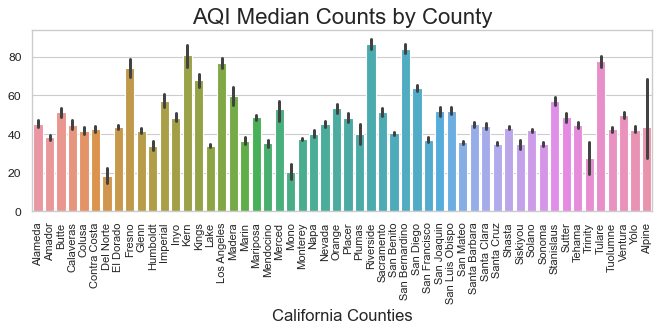

In [21]:
aqi_county_counts = aqi_county_CA["Median AQI"].value_counts().head(10)
top_10 = aqi_county_counts.index.tolist()
plt.rcParams['figure.dpi'] = 80
sns.set(style="whitegrid", font_scale=1)
sns.set(rc={'figure.figsize':(10,3)})

sns.set_color_codes('muted')
sns.set(style="whitegrid")
top_10df = aqi_county_CA[aqi_county_CA["Median AQI"].isin(top_10)]


county_aqi_plot = sns.barplot(x=aqi_county_CA["County"],y=aqi_county_CA["Median AQI"])
county_aqi_plot.set_ylabel("", fontsize = 15)
county_aqi_plot.set_xlabel("California Counties", fontsize = 15)
county_aqi_plot.set_title("AQI Median Counts by County", fontsize = 20)
ignorethis = county_aqi_plot.set_xticklabels(aqi_county_CA["County"].unique().astype(str), rotation='vertical', fontsize=10)

figure = county_aqi_plot.get_figure()    

Above is the average AQI counts by County for all counties since 2010 up until 2019.



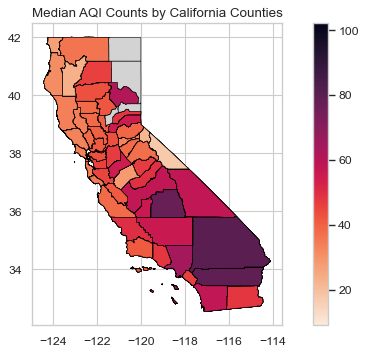

In [22]:
merged = map_df.set_index("County").join(aqi_county_CA.set_index("County"))
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
merged.plot(column='Median AQI',
            cmap='rocket_r',
            linewidth=0.5,
            edgecolor="black",
            legend=True, ax=ax, missing_kwds={
            "color": "lightgrey",
            "label": "Missing values",},)
ax.set_title('Median AQI Counts by California Counties', fontsize=12);

#fig = merged.get_figure()   

Above is the median air quality index by county by 2010 til 2021.

We will choose some counties to see some general patterns in different parts of the state California.

## Exploring AQI data by County Visualization

<Figure size 800x240 with 0 Axes>

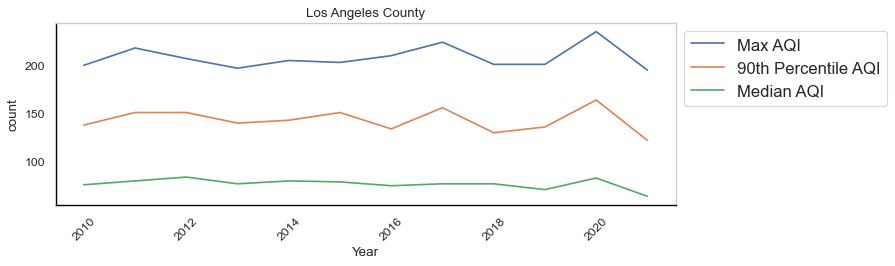

In [23]:
# kinda south part
SD = aqi_county_CA[aqi_county_CA['County'] == 'Los Angeles']
fig = plt.figure();
SD.plot(x='Year', rot=45, y=['Max AQI', '90th Percentile AQI', 'Median AQI'])
plt.legend(bbox_to_anchor=(1, 0.5), loc='lower left', prop={'size':15})
plt.title('Los Angeles County')
plt.xlabel('Year')
plt.ylabel('count')
plt.grid(b=False)
ax = plt.gca()
ax.set_facecolor('white')
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
plt.show()

<Figure size 800x240 with 0 Axes>

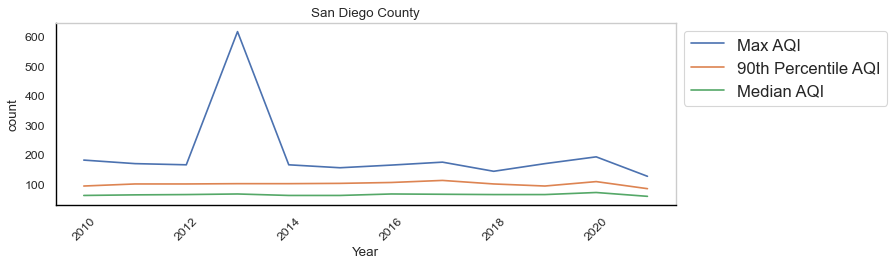

In [24]:
# southern most part
SD = aqi_county_CA[aqi_county_CA['County'] == 'San Diego']
fig = plt.figure();
SD.plot(x='Year', rot=45, y=['Max AQI', '90th Percentile AQI', 'Median AQI'])
plt.legend(bbox_to_anchor=(1, 0.5), loc='lower left', prop={'size':15})
plt.title('San Diego County')
plt.xlabel('Year')
plt.ylabel('count')
plt.grid(b=False)
ax = plt.gca()
ax.set_facecolor('white')
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
plt.show()

<Figure size 800x240 with 0 Axes>

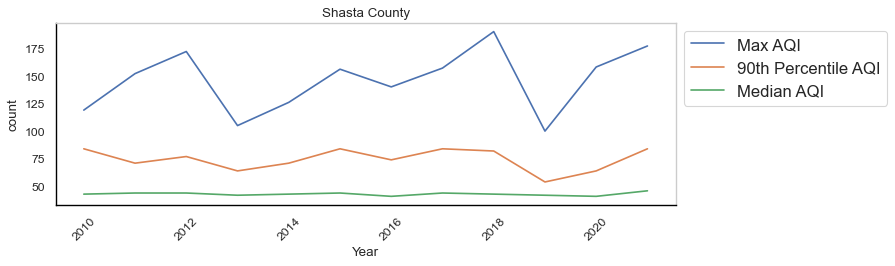

In [25]:
# Northern most part
Sh = aqi_county_CA[aqi_county_CA['County'] == 'Shasta']
fig = plt.figure();
Sh.plot(x='Year', rot=45, y=['Max AQI', '90th Percentile AQI', 'Median AQI'])
plt.legend(bbox_to_anchor=(1, 0.5), loc='lower left', prop={'size':15})
plt.title('Shasta County')
plt.xlabel('Year')
plt.ylabel('count')
plt.grid(b=False)
ax = plt.gca()
ax.set_facecolor('white')
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
plt.show()

<Figure size 800x240 with 0 Axes>

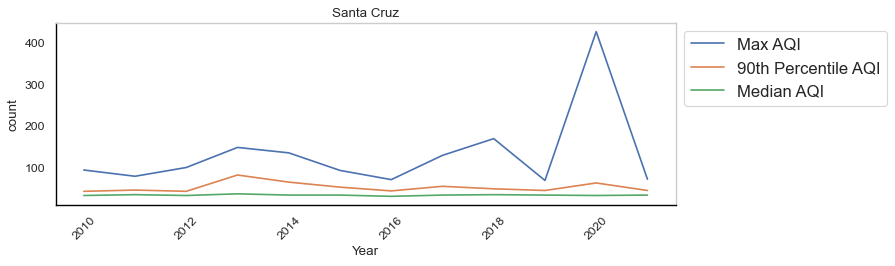

In [26]:
# West part
Sc = aqi_county_CA[aqi_county_CA['County'] == 'Santa Cruz']
fig = plt.figure();
Sc.plot(x='Year', rot=45, y=['Max AQI', '90th Percentile AQI', 'Median AQI'])
plt.legend(bbox_to_anchor=(1, 0.5), loc='lower left', prop={'size':15})
plt.title('Santa Cruz')
plt.xlabel('Year')
plt.ylabel('count')
plt.grid(b=False)
ax = plt.gca()
ax.set_facecolor('white')
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
plt.show()

<Figure size 800x240 with 0 Axes>

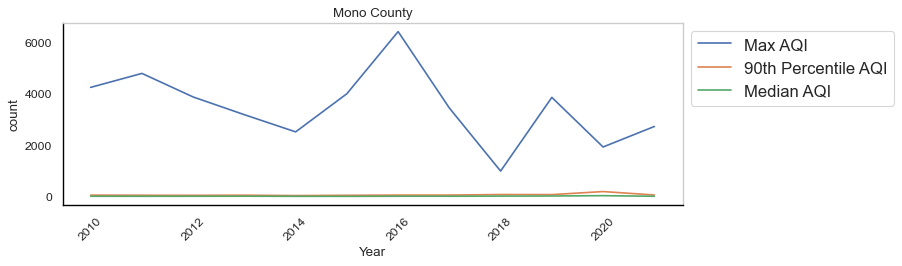

In [27]:
# East part
M = aqi_county_CA[aqi_county_CA['County'] == 'Mono']
fig = plt.figure();
M.plot(x='Year', rot=45, y=['Max AQI','90th Percentile AQI', 'Median AQI'])
plt.legend(bbox_to_anchor=(1, 0.5), loc='lower left', prop={'size':15})
plt.title('Mono County')
plt.xlabel('Year')
plt.ylabel('count')
plt.grid(b=False)
ax = plt.gca()
ax.set_facecolor('white')
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
plt.show()

<Figure size 800x240 with 0 Axes>

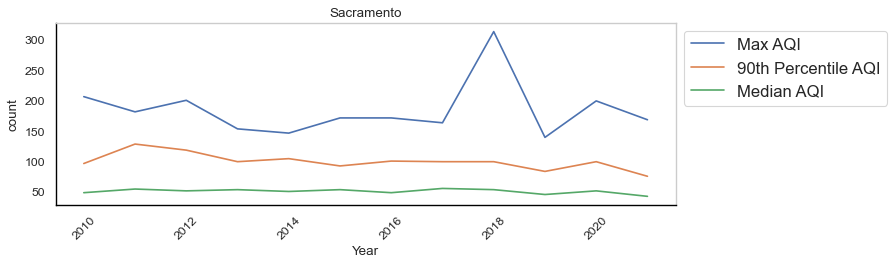

In [28]:
#Central
#North part
Sa = aqi_county_CA[aqi_county_CA['County'] == 'Sacramento']
fig = plt.figure();
Sa.plot(x='Year', rot=45, y=['Max AQI', '90th Percentile AQI', 'Median AQI'])
plt.legend(bbox_to_anchor=(1, 0.5), loc='lower left', prop={'size':15})
plt.title('Sacramento')
plt.xlabel('Year')
plt.ylabel('count')
plt.grid(b=False)
ax = plt.gca()
ax.set_facecolor('white')
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
plt.show()

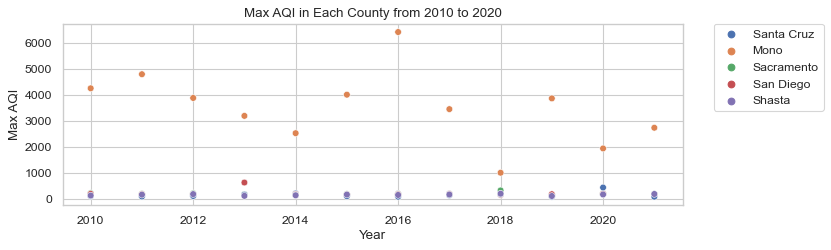

In [29]:
fh = aqi_county[aqi_county['County'].isin(['San Diego','Sacramento','Mono','Shasta','Santa Cruz'])]
ax = sns.scatterplot(data=fh, x='Year', y='Max AQI', hue='County')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_title('Max AQI in Each County from 2010 to 2020');

Above is the max air quality count in these five district from 2010 to 2021.

# Exploring traffic data by county Visualization

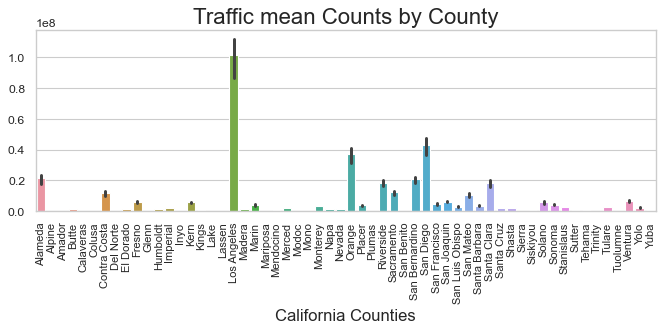

In [30]:
traffic_counties_counts= traffic_counties['Mean_AADT'].value_counts().head(10)
top_10 = traffic_counties_counts.index.tolist()
plt.rcParams['figure.dpi'] = 80
sns.set(style="whitegrid", font_scale=1)
sns.set(rc={'figure.figsize':(10,3)})

sns.set_color_codes('muted')
sns.set(style="whitegrid")
top_10df = traffic_counties[traffic_counties['Mean_AADT'].isin(top_10)]


traffic_counties_plot = sns.barplot(x=traffic_counties["County"],y=traffic_counties['Mean_AADT'])
traffic_counties_plot.set_ylabel("", fontsize = 15)
traffic_counties_plot.set_xlabel("California Counties", fontsize = 15)
traffic_counties_plot.set_title("Traffic mean Counts by County", fontsize = 20)
ignorethis = traffic_counties_plot.set_xticklabels(traffic_counties["County"].unique().astype(str), rotation='vertical', fontsize=10)

figure1 = traffic_counties_plot.get_figure()    
figure1.savefig("AADTmean_Bar_Chart.png", dpi=100)

Above is the average traffic mean by county for the years 2010 to 2020.

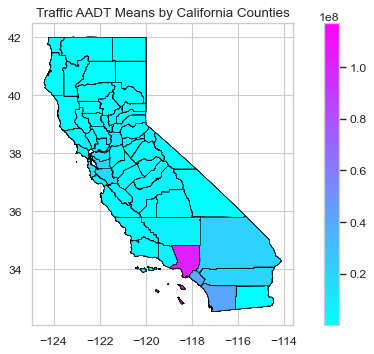

In [31]:
merged = map_df.set_index("County").join(traffic_counties.set_index("County"))
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
merged.plot(column='Mean_AADT',
            cmap='cool',
            linewidth=0.5,
            edgecolor="black",
            legend=True, ax=ax, missing_kwds={
            "color": "lightgrey",
            "label": "Missing values",},)
ax.set_title('Traffic AADT Means by California Counties', fontsize=12);

Above is the average traffic count by county in years 2010 through 2020.

# Traffic data for the chosen counties

Below are graphs of the average traffic count from years 2007 to 2020 showing average traffic counts.

<Figure size 800x240 with 0 Axes>

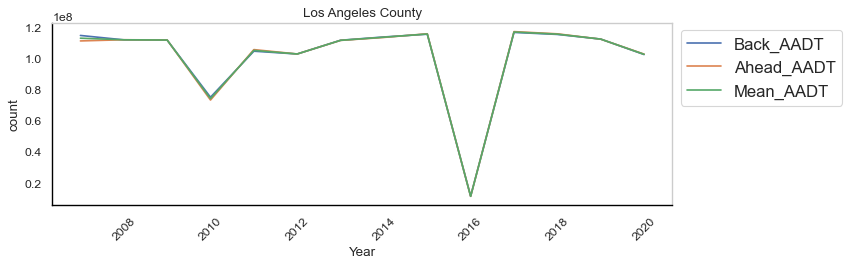

In [32]:
SDT = traffic_counties[traffic_counties['County'] == 'Los Angeles']
fig = plt.figure();
SDT.plot(x='Year', rot=45, y=['Back_AADT', 'Ahead_AADT', 'Mean_AADT'])
plt.legend(bbox_to_anchor=(1, 0.5), loc='lower left', prop={'size':15})
plt.title('Los Angeles County')
plt.xlabel('Year')
plt.ylabel('count')
plt.grid(b=False)
ax = plt.gca()
ax.set_facecolor('white')
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
plt.show()

<Figure size 800x240 with 0 Axes>

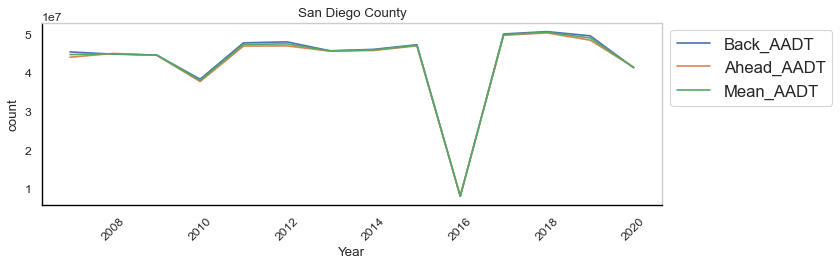

In [33]:
SDT = traffic_counties[traffic_counties['County'] == 'San Diego']
fig = plt.figure();
SDT.plot(x='Year', rot=45, y=['Back_AADT', 'Ahead_AADT', 'Mean_AADT'])
plt.legend(bbox_to_anchor=(1, 0.5), loc='lower left', prop={'size':15})
plt.title('San Diego County')
plt.xlabel('Year')
plt.ylabel('count')
plt.grid(b=False)
ax = plt.gca()
ax.set_facecolor('white')
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
plt.show()

<Figure size 800x240 with 0 Axes>

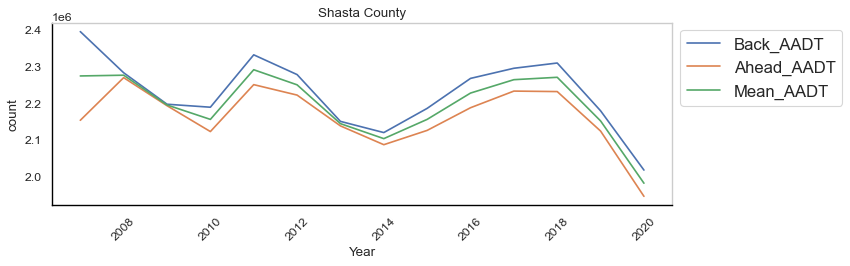

In [34]:
ST = traffic_counties[traffic_counties['County'] == 'Shasta']
fig = plt.figure();
ST.plot(x='Year', rot=45, y=['Back_AADT', 'Ahead_AADT', 'Mean_AADT'])
plt.legend(bbox_to_anchor=(1, 0.5), loc='lower left', prop={'size':15})
plt.title('Shasta County')
plt.xlabel('Year')
plt.ylabel('count')
plt.grid(b=False)
ax = plt.gca()
ax.set_facecolor('white')
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
plt.show()

<Figure size 800x240 with 0 Axes>

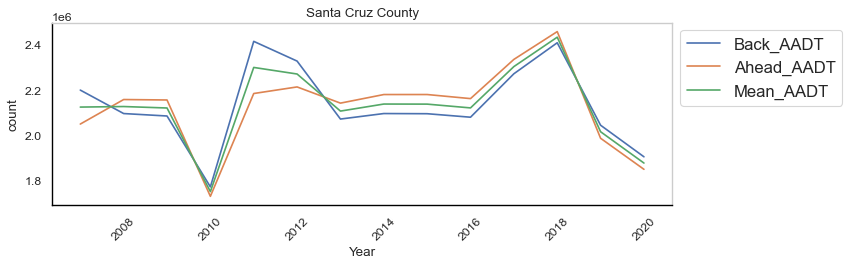

In [35]:
SCT = traffic_counties[traffic_counties['County'] == 'Santa Cruz']
fig = plt.figure();
SCT.plot(x='Year', rot=45, y=['Back_AADT', 'Ahead_AADT', 'Mean_AADT'])
plt.legend(bbox_to_anchor=(1, 0.5), loc='lower left', prop={'size':15})
plt.title('Santa Cruz County')
plt.xlabel('Year')
plt.ylabel('count')
plt.grid(b=False)
ax = plt.gca()
ax.set_facecolor('white')
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
plt.show()

<Figure size 800x240 with 0 Axes>

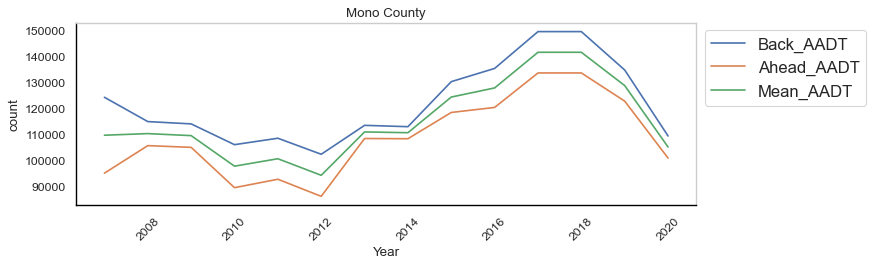

In [36]:
MT = traffic_counties[traffic_counties['County'] == 'Mono']
fig = plt.figure();
MT.plot(x='Year', rot=45, y=['Back_AADT', 'Ahead_AADT', 'Mean_AADT'])
plt.legend(bbox_to_anchor=(1, 0.5), loc='lower left', prop={'size':15})
plt.title('Mono County')
plt.xlabel('Year')
plt.ylabel('count')
plt.grid(b=False)
ax = plt.gca()
ax.set_facecolor('white')
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
plt.show()

<Figure size 800x240 with 0 Axes>

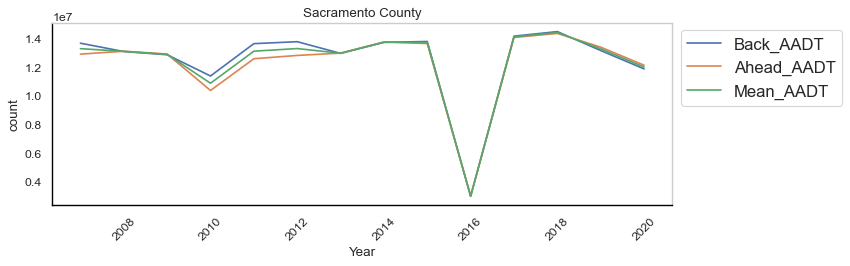

In [37]:
SMT = traffic_counties[traffic_counties['County'] == 'Sacramento']
fig = plt.figure();
SMT.plot(x='Year', rot=45, y=['Back_AADT', 'Ahead_AADT', 'Mean_AADT'])
plt.legend(bbox_to_anchor=(1, 0.5), loc='lower left', prop={'size':15})
plt.title('Sacramento County')
plt.xlabel('Year')
plt.ylabel('count')
plt.grid(b=False)
ax = plt.gca()
ax.set_facecolor('white')
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
plt.show()

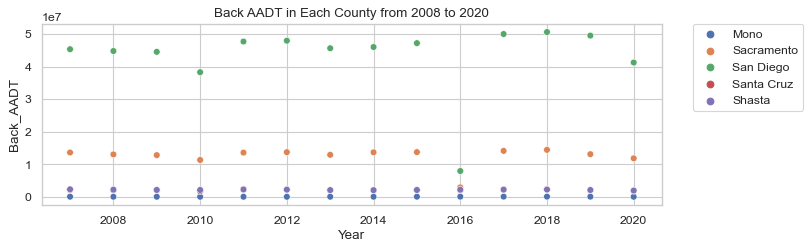

In [38]:
back = traffic_counties[traffic_counties['County'].isin(['San Diego','Sacramento','Mono','Shasta','Santa Cruz'])]
ax = sns.scatterplot(data=back, x='Year', y='Back_AADT', hue='County')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_title('Back AADT in Each County from 2008 to 2020');

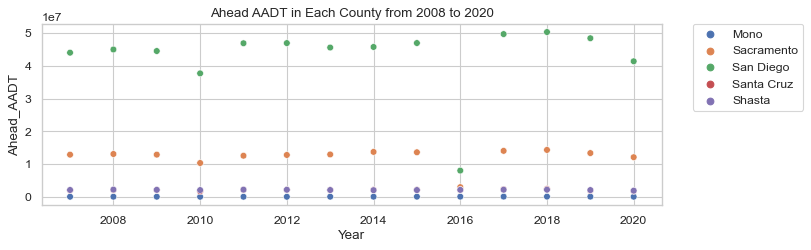

In [39]:
ahead = traffic_counties[traffic_counties['County'].isin(['San Diego','Sacramento','Mono','Shasta','Santa Cruz'])]
ax = sns.scatterplot(data=ahead, x='Year', y='Ahead_AADT', hue='County')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_title('Ahead AADT in Each County from 2008 to 2020');

## Gasoline Data 

###  Annual Gasoline Sales by City


In [40]:
# We need to change values to be numeric in order to graph

columns = list(gas_sales)

# Dont change City column
columns.pop(0)
columns.pop(0)

# Remove commas from Dataframe
gas_sales.replace(',' , '', regex=True, inplace=True)

# Iterate through columns (not including City)
for column in columns:
    gas_sales[column] = pd.to_numeric(gas_sales[column])

gas_sales.head()

,State,County,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,California,Los Angeles,576975774,569572568,513096586,462203720,489927305,577624448,597482538,553325286,551182317,434124374
1,California,San Diego,435507017,418994094,350573480,382951006,429738409,458149963,478402573,463772772,454951806,351446047
2,California,Sacramento,259938992,260349538,255080126,174054379,255968575,278560889,283805191,264019029,278151293,245128423
3,California,San Jose,299816301,292742725,278676054,218224534,286512916,324059453,318609135,298305348,311325761,234628392
4,California,Bakersfield,193751205,193930997,178563239,168800299,181022100,221473122,216668139,204619282,204009437,190635868


In [41]:
# Rename City column to Year before transpose
gas_sales_adjust = gas_sales.rename(columns= {'County': 'Year'})

# Transpose data frame to get City names as columns (more sensible choice to graph)
gas_sales_T = gas_sales_adjust.T
gas_sales_T = gas_sales_T.reset_index()

# Adjust header for simplicity of Dataframe
new_header = gas_sales_T.iloc[1]
gas_sales_T = gas_sales_T[2:] 
gas_sales_T.columns = new_header

gas_sales_T.head()

1,Year,Los Angeles,San Diego,Sacramento,San Jose,Bakersfield,Fresno,Riverside,Long Beach,Stockton,...,San Carlos,Mariposa,Rowland Heights,Jamestown,Avenal,Paradise,Dos Palos,Quincy,Angels Camp,Needles
2,2011,576975774,435507017,259938992,299816301,193751205,153551549,119783639,128655637,102327132,...,7125545,4184662,6584746,3186398,5057154,9459933,1963102,4531877,2797978,2450049
3,2012,569572568,418994094,260349538,292742725,193930997,156402195,119021979,133577640,96311073,...,7170437,3346722,8350514,2797816,3681337,6628310,2158303,2418894,1663664,1585251
4,2013,513096586,350573480,255080126,278676054,178563239,144276265,115580252,121448936,97022604,...,7514833,2247337,7940591,2802844,4502712,6579072,3144116,1577234,1045570,1794034
5,2014,462203720,382951006,174054379,218224534,168800299,108242443,115096900,124874409,79808881,...,4569340,5283946,7857678,2839468,3902354,6023551,3119857,2659001,1470884,1828995
6,2015,489927305,429738409,255968575,286512916,181022100,153759361,127251421,120041337,94937886,...,5726288,3986742,6012908,3319446,5114578,7181204,2549044,2221433,1913018,2259731


In [42]:
# Change values in transposed dataframe to be numeric
columns = list(gas_sales_T)

for column in columns:
    gas_sales_T[column] = pd.to_numeric(gas_sales_T[column])
    

gas_sales["Mean Sales"] = gas_sales[["2011","2012","2013","2014","2015","2016","2017","2018","2019","2020"]].mean(1)

## Gasoline Sales throughout California for specific years
Below are histograms of cities' gas usage per year, with the Y-Label being the amount of cities in that bin, while the X label is the amount of gasoline sold per year by 1,000,000.

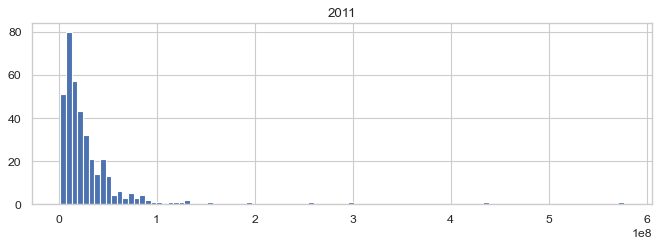

In [43]:
# Histogram for 2011 gasoline sales across California
gas_sales_hist = gas_sales.hist(column = '2011', bins = 100)

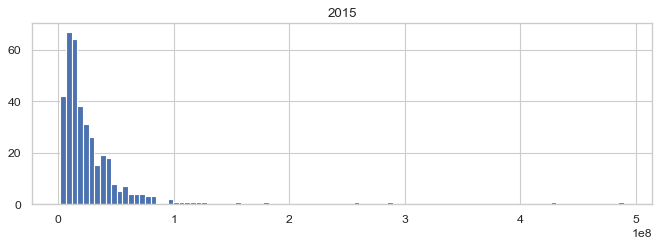

In [44]:
# Histogram for 2015 gasoline sales across California
gas_sales_hist = gas_sales.hist(column = '2015', bins = 100)

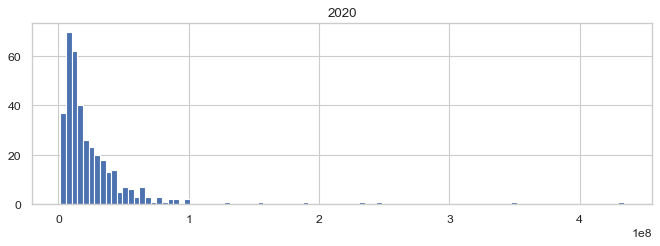

In [45]:
# Histogram for 2020 gasoline sales across California
gas_sales_hist = gas_sales.hist(column = '2020', bins = 100)

## Gasoline Sales over time by City

Text(0.5, 1.0, 'Los Angeles Gasoline Sales over time')

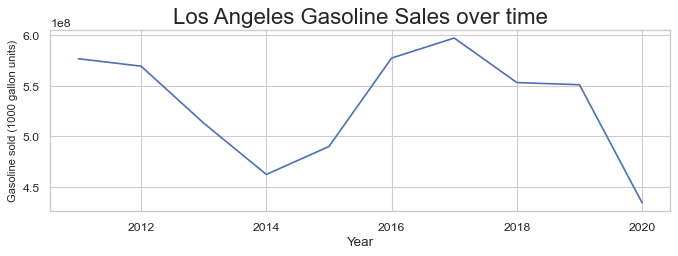

In [46]:
la_gas_plot = sns.lineplot(x='Year', y='Los Angeles', data = gas_sales_T)
la_gas_plot.set_ylabel("Gasoline sold (1000 gallon units)", fontsize = 10)
la_gas_plot.set_title("Los Angeles Gasoline Sales over time", fontsize = 20)

Text(0.5, 1.0, 'San Diego Gasoline Sales over time')

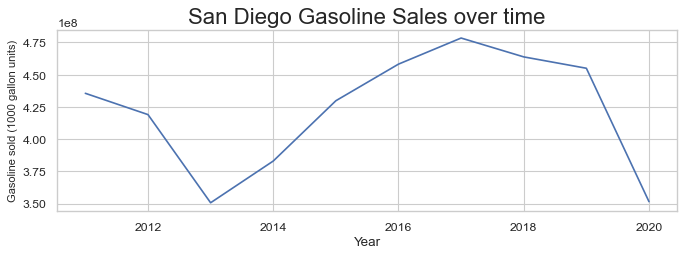

In [47]:
sd_gas_plot = sns.lineplot(x='Year', y='San Diego', data = gas_sales_T)
sd_gas_plot.set_ylabel("Gasoline sold (1000 gallon units)", fontsize = 10)
sd_gas_plot.set_title("San Diego Gasoline Sales over time", fontsize = 20)

Text(0.5, 1.0, 'Sacramento Gasoline Sales over time')

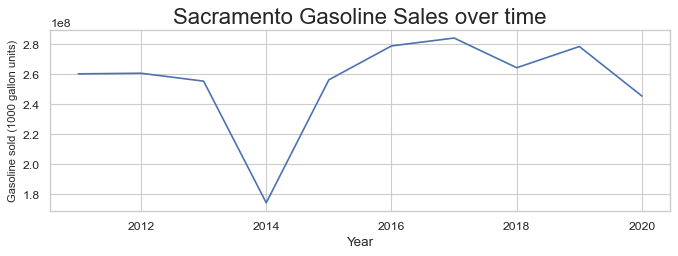

In [48]:
sac_gas_plot = sns.lineplot(x='Year', y='Sacramento', data = gas_sales_T)
sac_gas_plot.set_ylabel("Gasoline sold (1000 gallon units)", fontsize = 10)
sac_gas_plot.set_title("Sacramento Gasoline Sales over time", fontsize = 20)

Text(0.5, 1.0, 'Santa Cruz Gasoline Sales over time')

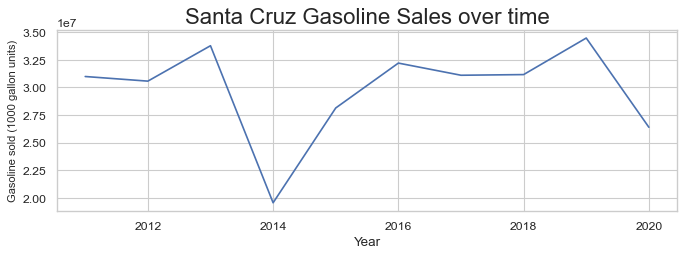

In [49]:
sc_gas_plot = sns.lineplot(x='Year', y='Santa Cruz', data = gas_sales_T)
sc_gas_plot.set_ylabel("Gasoline sold (1000 gallon units)", fontsize = 10)
sc_gas_plot.set_title("Santa Cruz Gasoline Sales over time", fontsize = 20)

Text(0.5, 1.0, 'Adelanto Gasoline Sales over time')

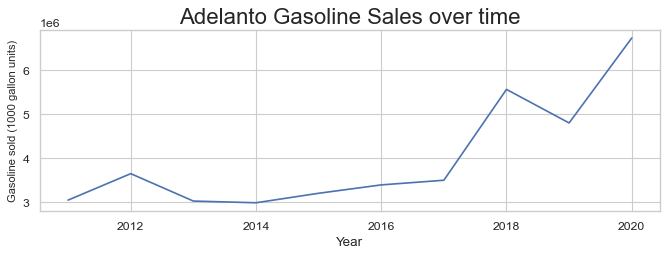

In [50]:
ad_gas_plot = sns.lineplot(x='Year', y='Adelanto', data = gas_sales_T)
ad_gas_plot.set_ylabel("Gasoline sold (1000 gallon units)", fontsize = 10)
ad_gas_plot.set_title("Adelanto Gasoline Sales over time", fontsize = 20)

Text(0.5, 1.0, 'Redding Gasoline Sales over time')

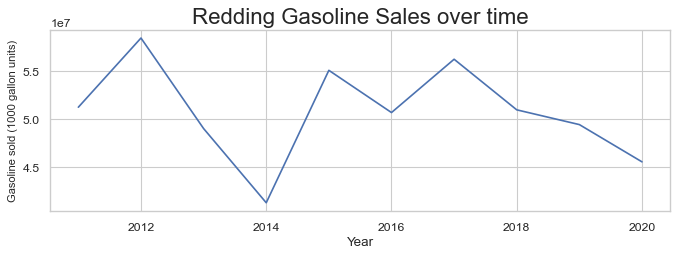

In [51]:
sc_gas_plot = sns.lineplot(x='Year', y='Redding', data = gas_sales_T)
sc_gas_plot.set_ylabel("Gasoline sold (1000 gallon units)", fontsize = 10)
sc_gas_plot.set_title("Redding Gasoline Sales over time", fontsize = 20)

Above are the Gasoline Sales Data for specific cities within California over the years 2011-2020

## Visualizing Outliers


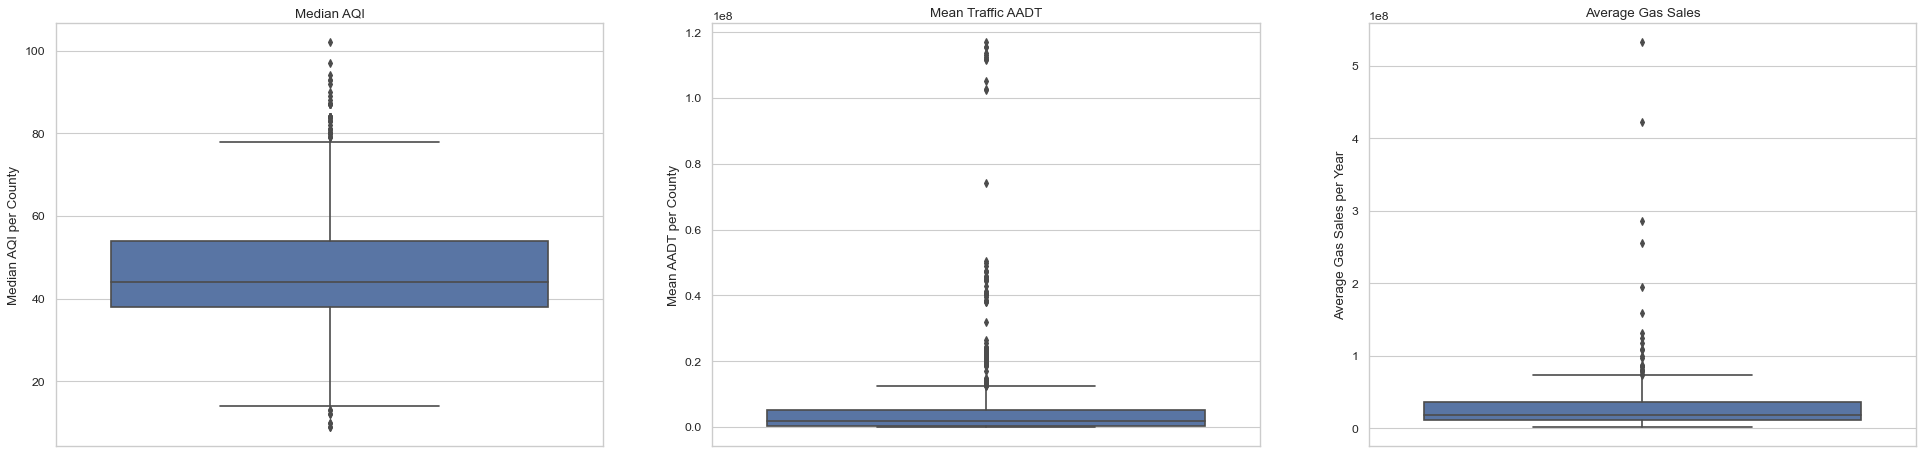

In [52]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(30,7)

sns.boxplot(y=aqi_county_CA['Median AQI'], ax=ax[0]).set(title="Median AQI", ylabel="Median AQI per County")
sns.boxplot(y=traffic_counties['Mean_AADT'],ax=ax[1]).set(title="Mean Traffic AADT", ylabel="Mean AADT per County")
sns.boxplot(y=gas_sales["Mean Sales"],ax=ax[2]).set(title="Average Gas Sales", ylabel="Average Gas Sales per Year")

plt.show()

## OLS Attempts

###  Attempting to do some Linear Regression


In [53]:
aqi_traffic = [aqi_county_CA, traffic_counties]

result_aqi_traffic = functools.reduce(lambda left,right: pd.merge(left,right, on=['County',"State","Year"], how='outer'), aqi_traffic).fillna('void')
# result_aqi_traffic = pd.concat(aqi_traffic)
result_aqi_traffic

,State,County,Year,Max AQI,90th Percentile AQI,Median AQI,Back_AADT,Ahead_AADT,Mean_AADT
0,California,Alameda,2010,179.0,68.0,43.0,14204650.0,13128700.0,13666675.0
1,California,Amador,2010,151.0,64.0,35.0,372950.0,329550.0,351250.0
2,California,Butte,2010,126.0,84.0,47.0,1344200.0,1289570.0,1316885.0
3,California,Calaveras,2010,154.0,84.0,41.0,254150.0,226450.0,240300.0
4,California,Colusa,2010,119.0,49.0,38.0,489080.0,369160.0,429120.0
...,...,...,...,...,...,...,...,...,...
858,California,Yuba,2016,void,void,void,932350.0,948100.0,940225.0
859,California,Yuba,2017,void,void,void,934250.0,963900.0,949075.0
860,California,Yuba,2018,void,void,void,958480.0,973550.0,966015.0
861,California,Yuba,2019,void,void,void,931642.0,902450.0,917046.0


In [54]:
#aqi_gas = [aqi_county_CA, gas_sales]

#result_aqi_gas = functools.reduce(lambda left,right: pd.merge(left,right, on=['County',"State","Year"], how='outer'), aqi_gas).fillna('void')
#result_aqi_gas

In [55]:
df_aqi_traffic = result_aqi_traffic[["Median AQI", "Mean_AADT"]]
df_aqi_traffic.columns = ["AQI", "Traffic"]

df_aqi_traffic["AQI"] = pd.to_numeric(df_aqi_traffic["AQI"], downcast="float", errors="coerce")
df_aqi_traffic["Traffic"] = pd.to_numeric(df_aqi_traffic["Traffic"], downcast="float", errors="coerce")

print(df_aqi_traffic.dtypes)

x = df_aqi_traffic["AQI"].tolist()
y = df_aqi_traffic["Traffic"].tolist()

ar_x=np.asarray(x)
ar_y=np.asarray(y)

#result = sm.OLS(ar_y,ar_x).fit()
outcome, predictors = patsy.dmatrices("AQI ~ Traffic", df_aqi_traffic, return_type = "dataframe")

mod_log = sm.OLS(outcome,predictors)
res_log = mod_log.fit()

print(res_log.summary())

df_aqi_traffic.head()

AQI        float32
Traffic    float32
dtype: object
                            OLS Regression Results                            
Dep. Variable:                    AQI   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     108.0
Date:                Tue, 01 Mar 2022   Prob (F-statistic):           2.42e-23
Time:                        09:43:03   Log-Likelihood:                -2415.9
No. Observations:                 589   AIC:                             4836.
Df Residuals:                     587   BIC:                             4845.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------


,AQI,Traffic
0,43.0,13666675.0
1,35.0,351250.0
2,47.0,1316885.0
3,41.0,240300.0
4,38.0,429120.0


### Confounds
There are a few possible confounding variables in our exploratory data analysis. First regarding the AQI counts, we thought that Max AQI could be a statistic that we may not want to use in the final analysis due to the possibility of there being a large outlier in measured air quality of one region during one day. We want to remove as many sources of error as possible, so taking outliers into consideration is something we will continue to do. Another possible confound is in the initial measuring of the Air Quality. Because we did not control the data gathering process but rather used data that we found online through government air quality monitering websites, we cannot ensure that each air quality measuring station in each county of California took equal steps to be placed in optimal locations, with optimal care. Unfortunately because we cannot see how the raw data was gathered, it is unfortunately difficult to account for this confound. Regardless, we thought it would be apt to discuss the possibility of this influencing our EDA.

As for the traffic data, there are also multiple potential confounds that we thought to be aware of. The first is, like the air quality data, we did not measure the traffic counts ourselves, so we are unable to guarantee that the traffic measurements were collected in each county through optimal means, or more specifically whether the AADT measurements were collected from the most relevant roads to the regional community. This could significantly impact the way we view the traffic counts over our years of data exploration, especially if an important or often used road was left off the measurements. However, like the air quality data, there is little we can do to account for this potential confound, so unfortunately we must take our data as is in this case. Another confound for traffic data we thought of was the possibility of construction or obstructions that block certain roads. We noticed a couple outliers in the traffic data while creating our visual plots, which can be seen in the plots for San Diego and Sacramento county traffic over time. There was a significant drop of traffic counts in both counties in the year 2016, which leads us to believe that there was either an obstruction of the road or an obstruction of the actual traffic measuring procedure that caused what seems to be an outlier. Because it is a line plot, we thought it was appropriate to still include this information in the plot, but we felt that it was important to mention this outlier in our data.

As for the gasoline sales data, we believed there were a few confounding variables that might lead to a skew in the data. Similar to the other datasets, we did not measure gasoline sales throughout cities in California, so we are unable to ensure that the measurements taken were by optimal means, or that the gasoline sales data was collected uniformly throughout each city in the dataset. This could potentially lead to a significant impact in the way that we analyze the gasoline data in regards to the other datasets and potential relationships. Similarly, we also noticed that there were outliers in the data, or more specifically that a couple of cities had substantially high gasoline sales throughout the years , and others had substantially low gasoline sales throughout the years,  as is seen when plotting a histogram for the gasoline sales throughout California for the years 2011, 2015, and 2020. Also we can see that for some cities, more than likely a large populated city, there is a drop in gasoline sales specifically around the year 2014, which we believe could lead to an impact in our analysis as well.


# Relationships
As of right now, the relationship between gasoline sales, traveling, and air quality are not that tight knit. It may be possible that we have not completed the full analysis of the counties to get a better idea of what's happening. We only have 5 counties to look over. Another thing that we may have to check out is the locations of the AQI sensors, it could cause a bias in how the data is collected. Another thing we need to consider is who's buying the gasoline in each county since some areas like LA took a dip in gasoline sales, but their traffic count barely decreased.